<a href="https://colab.research.google.com/github/Parkyosep/Paper/blob/main/AlexNet/Alexnet(Pytorch).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from torchsummary import summary
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils import data
import torchvision.datasets as datasets
import torchvision.transforms as transforms

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
if torch.cuda.is_available():
  device_count = torch.cuda.device_count()
  print("device_count: {}".format(device_count))
  for device_num in range(device_count):
    print("device {} capability {}".format(
        device_num, torch.cuda.get_device_capability(device_num)))
    print("device {} name {}".format(
        device_num, torch.cuda.get_device_name(device_num)))
else:
  print("no cuda device")

device_count: 1
device 0 capability (7, 5)
device 0 name Tesla T4


In [ ]:
# Alexnet in Paper

batch_size = 128
momentum = 0.9
weight_decay = 0.0005
lr_init = 0.01
image_dim = 227
num_classes = 1000

class AlexNet(nn.Module):
    def __init__(self, num_classes = 1000):
        super().__init__()

        # CNN layers
        self.layers = nn.Sequential(
            # conv1
            nn.Conv2d(in_channels=3, out_channels=96,kernel_size=11, stride=4),
            nn.ReLU(inplace=True), # inplace True means change input value as ReLU value
            nn.LocalResponseNorm(size=5, alpha=0.0001, beta=0.75, k=2), # used same parameter in paper
            nn.MaxPool2d(kernel_size=3, stride=2),
            # conv2
            nn.Conv2d(in_channels=96, out_channels=256, kernel_size=5, stride=1, padding=2),
            nn.ReLU(inplace=True),
            nn.LocalResponseNorm(size=5, alpha=0.0001, beta=0.75, k=2),
            nn.MaxPool2d(kernel_size=3, stride=2),
            # conv3
            nn.Conv2d(in_channels=256, out_channels=384, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            # conv4
            nn.Conv2d(in_channels=384, out_channels=384, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            # conv5
            nn.Conv2d(in_channels=384, out_channels=256, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            
        )

        # FC layers
        self.classifier = nn.Sequential(
            # fc1
            nn.Dropout(p=0.5),
            nn.Linear(in_features=(256*6*6), out_features=4096),
            nn.ReLU(inplace=True),
            # fc2
            nn.Dropout(p=0.5),
            nn.Linear(in_features=4096, out_features=4096),
            nn.ReLU(inplace=True),
            nn.Linear(in_features=4096, out_features=num_classes),

        )

        # initialize bias, weight
        def init_bias_weights(self):
            for layer in self.layers:
                if isinstance(layer, nn.Conv2d): # if layer is Conv
                    nn.init.normal_(layer.weight, mean=0, std=0.01) # Gaussian Distribution with (0, 0.01)
                    nn.init.constant_(layer.bias, 0) # default=0, 1 for 2, 4, 5, FC
            # conv2, 4, 5 bias for 1
            nn.init.constant_(self.layers[4].bias, 1)
            nn.init.constant_(self.layers[10].bias, 1)
            nn.init.constant_(self.layers[12].bias, 1)
            # FC bias for 1
            nn.init.constant_(self.classifier[1].bias, 1)
            nn.init.constant_(self.classifier[4].bias, 1)
            nn.init.constant_(self.classifier[6].bias, 1)

    def forward(self, x):
        x = self.layers(x)
        x = torch.flatten(x, 1)
        return self.classifier(x)

if __name__ == "__main__": 

    model = AlexNet().to(device)
    
    print(summary(model, (3, 227, 227))) 

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 96, 55, 55]          34,944
              ReLU-2           [-1, 96, 55, 55]               0
 LocalResponseNorm-3           [-1, 96, 55, 55]               0
         MaxPool2d-4           [-1, 96, 27, 27]               0
            Conv2d-5          [-1, 256, 27, 27]         614,656
              ReLU-6          [-1, 256, 27, 27]               0
 LocalResponseNorm-7          [-1, 256, 27, 27]               0
         MaxPool2d-8          [-1, 256, 13, 13]               0
            Conv2d-9          [-1, 384, 13, 13]         885,120
             ReLU-10          [-1, 384, 13, 13]               0
           Conv2d-11          [-1, 384, 13, 13]       1,327,488
             ReLU-12          [-1, 384, 13, 13]               0
           Conv2d-13          [-1, 256, 13, 13]         884,992
             ReLU-14          [-1, 256,

In [ ]:
train = datasets.CIFAR10(root='data', 
                         train=True, 
                         download=True,
                         transform = transforms.ToTensor() 
                         )

import numpy as np
def print_stats(dataset):
    imgs = np.array([img.numpy() for img, _ in dataset])

    mean_r = np.mean(imgs, axis=(2, 3))[:, 0].mean()
    mean_g = np.mean(imgs, axis=(2, 3))[:, 1].mean()
    mean_b = np.mean(imgs, axis=(2, 3))[:, 2].mean()

    std_r = np.std(imgs, axis=(2, 3))[:, 0].std()
    std_g = np.std(imgs, axis=(2, 3))[:, 1].std()
    std_b = np.std(imgs, axis=(2, 3))[:, 2].std()
    
    print(f'mean: {mean_r, mean_g, mean_b}')
    print(f'std: {std_r, std_g, std_b}')
    return mean_r, mean_g, mean_b, std_r, std_g, std_b

mean_r, mean_g, mean_b, std_r, std_g, std_b = print_stats(train)

mean: (0.49139965, 0.48215845, 0.4465309)
std: (0.060528398, 0.061124973, 0.06764512)


In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((mean_r, mean_g, mean_b),(std_r, std_g, std_b)),
    transforms.Resize((227, 227))
])

trainset = datasets.CIFAR10(root='data',
                            train=True,
                            download=True,
                            transform=transform)

testset = datasets.CIFAR10(root='data',
                           train=False,
                           download=True,
                           transform=transform)

trainloader = data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
testloader = data.DataLoader(testset, batch_size=batch_size, shuffle=True)

Files already downloaded and verified
Files already downloaded and verified


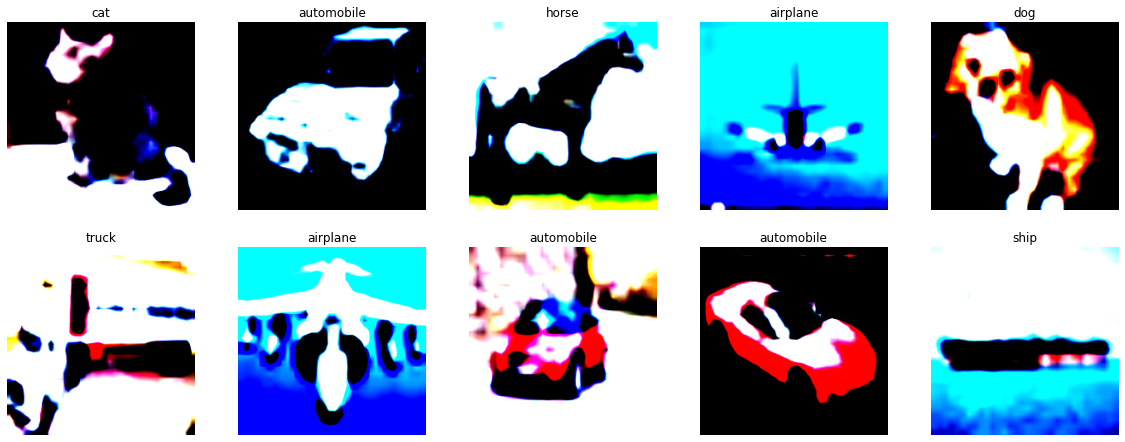

In [ ]:
import matplotlib.pyplot as plt
def show_one_image(img):
    img = img.numpy()
    plt.imshow(np.transpose(img, (1, 2, 0)))
    plt.show()

inputs, classes = next(iter(trainloader))
idx_to_name = {
    0: 'airplane',
    1: 'automobile',
    2: 'bird',
    3: 'cat',
    4: 'deer',
    5: 'dog',
    6: 'frog',
    7: 'horse',
    8: 'ship',
    9: 'truck'
}
titles = [idx_to_name[classes[i].numpy().item()] for i in range(10)]

plt.figure(figsize=(20,20))
for i in range(10):
    img = inputs[i].numpy()
    plt.subplot(5, 5, i+1)
    plt.title(titles[i])
    plt.imshow(np.transpose(img, (1, 2, 0)))
    plt.axis('off')

plt.show()

In [ ]:
model = AlexNet(num_classes=10).to(device)

n = len(trainloader)
optimizer = optim.SGD(model.parameters(), lr=lr_init, momentum=momentum)
import time
start_time = time.time()
loss_fn = nn.CrossEntropyLoss()

loss_ = []


for epoch in range(90): # in paper they trained 90 cycle
    running_loss = 0.0
    for data in trainloader:
        inputs, labels = data[0].to(device), data[1].to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    loss_.append(running_loss / n)
    print('[%d] loss: %.3f' %(epoch+1, running_loss/n))



[1] loss: 1.951


KeyboardInterrupt: ignored